# Transverse Field Ising Model

In [1]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector, Pauli
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import QFT

from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import expm

from matplotlib.ticker import FuncFormatter

## Table of Contents

* [Methods](#Methods)
* [Overview](#Overview)
* [Hamiltonian Decomposition](#Hamiltonian-Decomposition)
* [Initialization](#Initialization)
* [Simulation](#Simulation)

## Methods

In [2]:
def create_tfim_hamiltonian(eigen_bits, g, quiet=False):
    # create an empty matrix that's the size of the system
    H = np.zeros((2**eigen_bits, 2**eigen_bits), dtype=np.complex128)

    # construct the Hamiltonian (when using Pauli Operators in Qiskit ^ represents a tensor product)
    if not quiet: print("H = ", end='')
    for i in range(eigen_bits-1):
        temp = Pauli('')
        for j in range(eigen_bits):
            if (j == i or j == i+1):
                temp ^= Pauli('Z')
            else:
                temp ^= Pauli('I')
        if not quiet: print("-"+str(temp)+" ", end='')
        H += -temp.to_matrix()
    for i in range(eigen_bits):
        temp = Pauli('')
        for j in range(eigen_bits):
            if (j == i):
                temp ^= Pauli('X')
            else:
                temp ^= Pauli('I')
        if not quiet: print("-"+str(g)+"*"+str(temp)+" ", end='')
        H += -g*temp.to_matrix()
    if not quiet: print("\n")
    
    # normalize the Hamiltonian
    H = (1/8)*H/np.linalg.norm(H, ord=2)
    
    # rotate matrix so that it will be positive definite
    H += 1/2*np.eye(2**eigen_bits)
    
    if not quiet: print("Eigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
    min_eigenvalue = np.min(np.linalg.eigvals(H))
    if not quiet: print("\nLowest energy Eigenvalue", min_eigenvalue)
    
    # convert revolutions to radians
    H *= 2*np.pi*1j
    
    # convert the rotations to complex numbers
    H = expm(H)
    return H

def create_graph(eigen_bits, qc, g):
    ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
    new_dist = {}
    for key in ideal_distribution:
        bin_num = key[eigen_bits:]
        try:
            new_dist[bin_num] += ideal_distribution[key]
        except:
            new_dist[bin_num] = ideal_distribution[key]
    # print(new_dist)
    fig,ax = plt.subplots()
    plt.xticks(rotation=90)
    plt.ylabel("Probability")
    plt.xlabel("Binary String")
    plt.title("QPE estimating TFIM with g="+str(g)) 
    plt.ylim([0,1.1])
    bar = ax.bar(new_dist.keys(), new_dist.values())
    plt.show()

def get_phase_from_qcircuit(eigen_bits, ancilla_bits, qc, quiet=False):
    ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
    max_num = 0
    binary_num = ''
    for key in ideal_distribution:
        if (ideal_distribution[key] > max_num):
            max_num = ideal_distribution[key]
            binary_num = key
            
    binary_num = binary_num[eigen_bits:]
    decimal_num = int(binary_num, 2) / (2 ** (ancilla_bits))

    if not quiet:
        # print("Lowest energy Eigenvalue", min_eigenvalue.real)
        print("Binary Number Output: 0."+str(binary_num))
        print("Decimal Number with Equivalent Value:",decimal_num)
    return decimal_num

## Overview
The transverse-field Ising model (TFIM) is a widely studied quantum spin system that captures fundamental features of quantum phase transitions and many-body quantum dynamics. It consists of a one-dimensional chain of spin-$\frac{1}{2}$ particles interacting with their nearest neighbors along the $z$-axis and subjected to an external magnetic field in the transverse $x$-direction.

Let $n\in\mathbb{N}$ denote the number of particles and $g\in\mathbb{R}_{\geq 0}$ the magnetic field strength. The governing matrix $H\in \mathbb{C}^{2^n \times 2^n}$ (the Hamiltonian) of the one-dimensional transverse-field Ising model with open boundary conditions is defined as
$$H = -\sum_{i=0}^{n-1} Z_iZ_{i+1} - g\sum_{i=0}^nX_i,$$
where $Z_i$ represents the Pauli-Z operator applied to the $i$th particle and $X_i$ represents the Pauli-$X$ operator applied to the $i$th particle.
    
The physical interpretation of the TFIM as defined above, is that $n$ describes the number of particles exposed to the transverse external magnetic field. The first term represents the nearest-neighbor coupling, while the second term describes the interaction with the magnetic field, where $g$ quantifies its strength.

The time evolution of a quantum system governed by this Hamiltonian satisfies the time-dependent Schrödinger equation:
$$ i \frac{\partial}{\partial t} |\psi(t) \rangle = H |\psi(t) \rangle,$$ 
with initial condition $|\psi(t=0)\rangle = |\psi_0\rangle$. The solution for $|\psi(t) \rangle$ is given by 
$$|\psi(t) \rangle = e^{-itH}|\psi_0\rangle.$$

Hence, simulating time evolution or extracting eigenvalues of $H$ reduces to computing the eigenphases of the unitary operator $U = e^{-itH}$,  which can be performed using QPE or related quantum algorithms.

## Hamiltonian Decomposition

To implement time evolution on a quantum computer, we must approximate the operator $U = e^{-itH}$. When $H$ is expressed as a sum of non-commuting components, care must be taken in the exponentiation.

Suppose
$$H = A + B.$$
where $A$ and $B$ are Pauli operators. Since $e^{H} \neq e^{A}e^{B}$ unless $A$ and $B$ commute, in general, the Lie Product formula must be applied to approximate the matrix $U$, i.e.,
$$e^{-itH} = \lim_{L \to \infty }\left(e^{-itA/L}e^{-itB/L}\right)^L,$$
where $L$ is the order of the expansion. This is known as the Trotter Suzuki decomposition.
Given the comparably large error contribution of noise to current quantum simulations, it suffices to approximate $U=e^{-itH}$ using a finite-order expansion.
$$e^{-itH} = \left(e^{-itA/L}e^{-itB/L}\right)^L \implies e^{-itH/L} = e^{-itA/L}e^{-itB/L}  $$
Before being able to determine the error of such an approximation, we first must find the error of a simpler expression. Defining $\delta$ as the difference between the terms in the above equation,
$$\delta = \left|e^{-itH/L} - e^{-itA/L}e^{-itB/L}\right|,$$
Taylor expanding the exponentials,
$$\delta = \left|\sum_{k=0}^\infty \frac{1}{k!}\left(-\frac{it}{L}H\right)^k - \sum_{k=0}^\infty \frac{1}{k!}\left(-\frac{it}{L}(A+B)\right)^k\right|$$
and writing out terms,
$$\delta = \left|\frac{1}{0!}(I-I)-\frac{1}{1!}\frac{it}{L}(H-H)+\mathcal{O}\left(\frac{1}{2!}\frac{t^2}{L^2}\left(H-(A+B)^2)\right)\right)\right| = \mathcal{O}\left(\frac{t^2}{L^2}\right).$$

Returning to determining the error of the finite expansion, let $\epsilon$ be the difference of the first two terms in the original expression, i.e.,   $$\epsilon = \left|e^{-itH}- \left(e^{-itA/L}e^{-itB/L}\right)^L\right|.$$
Notice that $\epsilon$ follows a similar form to $\delta$, but is raised to the power of $L$. Therefore it is safe to assume the order of $\epsilon$ is $L$ times the order of $\delta$. That means to get precision $\epsilon$, 
$$\epsilon = \mathcal{O}\left(\frac{t^2}{L}\right) \implies L = \mathcal{O}\left(\frac{t^2}{\epsilon}\right).$$
Note that even with a perfect decomposition to Pauli operators, for discrete L, this is an approximation so there is still error in simulation as long as the Pauli operators do not commute. However, in case of the TFIM, there are methods to exactly simulate the system making it a valuable testbed for quantum algorithm development, allowing exploration of algorithmic behavior under both commuting and non-commuting dynamics.

## Initialization

While QPE can estimate eigenvalues of any unitary operator, its success depends on preparing an initial state with sufficient overlap with
the target eigenstate (typically the ground state). This initial guess is known as the ansatz. 

To explore this sensitivity, consider the TFIM with $n=4$ spins and magnetic field strength $g=10$. Different initial states were prepared by applying a single-qubit $R_y(\theta)$ gate to each qubit, with $\theta$ ranging from 0 to $2\pi$. This rotation spans a full set of superpositions about the $y$ axis between $|0\rangle$ and $|1\rangle$, thereby modifying the overlap with the true ground state. The plot below illustrates that the accuracy of the QPE estimate varies with the ansatz, demonstrating the importance of physically informed initialization strategies.

In [3]:
eigen_bits = 4
g = 10
ancilla_bits = 4
H = create_tfim_hamiltonian(eigen_bits, g)
rotation_axis = 'y'

H = -ZZII -IZZI -IIZZ -10*XIII -10*IXII -10*IIXI -10*IIIX 

Eigenvalues of the Hamiltonian:
 [0.625     +0.j 0.375     +0.j 0.55750815+0.j 0.5643727 +0.j
 0.43240364+0.j 0.4394772 +0.j 0.49303095+0.j 0.50696905+0.j
 0.49989549+0.j 0.50010451+0.j 0.56759636+0.j 0.5605228 +0.j
 0.4356273 +0.j 0.44249185+0.j 0.49688085+0.j 0.50311915+0.j]

Lowest energy Eigenvalue (0.37500000000000006+0j)


In [4]:
trials = 100
rot_outputs = []
for angle in np.linspace(0,2*pi, trials):
    qr_ancilla = QuantumRegister(ancilla_bits)
    qr_eigenstate = QuantumRegister(eigen_bits)
    cr = ClassicalRegister(ancilla_bits)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    
    # prepare state
    qc.h(qr_ancilla)
    if rotation_axis == 'x':
        qc.rx(angle, qr_eigenstate)
    if rotation_axis == 'y':
        qc.ry(angle, qr_eigenstate)
    if rotation_axis == 'z':
        qc.rz(angle, qr_eigenstate)
    
    for i in range(ancilla_bits):
        mat = np.linalg.matrix_power(H, 2**(i))
        controlled_U = UnitaryGate(mat).control(annotated="yes")
        qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )
    
    qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
    qc.draw('mpl')
    rot_outputs.append(get_phase_from_qcircuit(eigen_bits, ancilla_bits, qc, quiet=True))

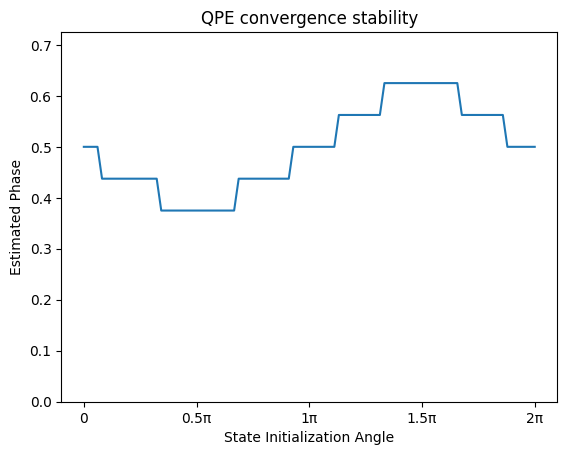

In [5]:
f,ax=plt.subplots(1)
ax.set_title("QPE convergence stability")
ax.set_ylabel("Estimated Phase")
ax.set_xlabel("State Initialization Angle")
ax.plot(np.linspace(0,2*pi, trials), rot_outputs, label = 'ry')
ax.set_ylim([0, max(rot_outputs)+.1])
ax.set_xticks(np.linspace(0,2*pi, 5))
ax.xaxis.set_major_formatter(FuncFormatter(lambda val,pos: '{:g}π'.format(val/np.pi) if val!=0 else '0'))
plt.show()

For QPE to yield reliable estimates, the initial state must have significant overlap with the target eigenstate. In the case of the TFIM, physically motivated initializations can be derived from the structure of the Hamiltonian matrix. When $g\ll 1$, the magnetic field term becomes negligible and the coupling term dominates, aligning spins along the $z$-axis. In this regime, initializing all qubits to $|0\rangle$ results in a large overlap with the ground state. 

Conversely, when $g\gg 1$, the magnetic field term dominates, favoring alignment with its eigenvectors—namely, the $x$-basis states $|+\rangle$ and $|-\rangle$. This can be achieved by applying Hadamard gates to each qubit. 

For intermediate values of $g$, where neither term is negligible, the ground state structure becomes more elaborate. However, the Hadamard-initialized state remains a reasonable heuristic, as it captures partial alignment along both axes. The quality of any ansatz ultimately depends on how much each term contributes to the system’s energy.

## Simulation

We exemplify the simulation of the TFIM with QPE using a Qiskit state vector emulator for the system parameters $n=4$ and $g=0$, $g=1$, and $g=10^{8}$. The system Hamiltonian was normalized and scaled by a factor of $1/8$ and increased by a factor of $1/2$, making the Hamiltonian positive definite, to scale the eigenvalues to be in the range $3/8$ to $5/8$. Following the state preparation outlined above, we initialize all qubits with $|0\rangle$ when $g=0$, and all qubits with $|+\rangle$ when $g=1$ and $g=10^8$. The ground state energy of the following examples is $0.375$ which is closest to the $4$-bit binary number $0.0110$.

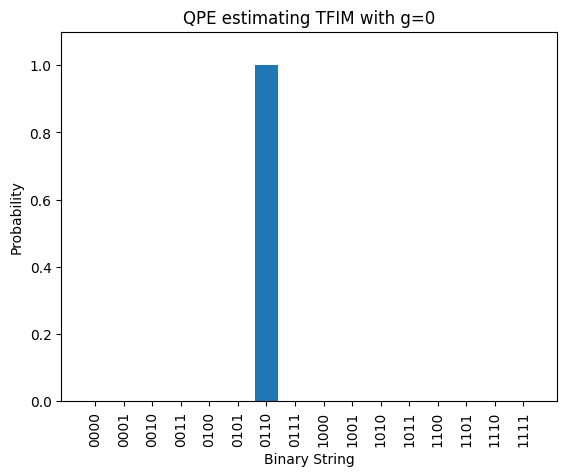

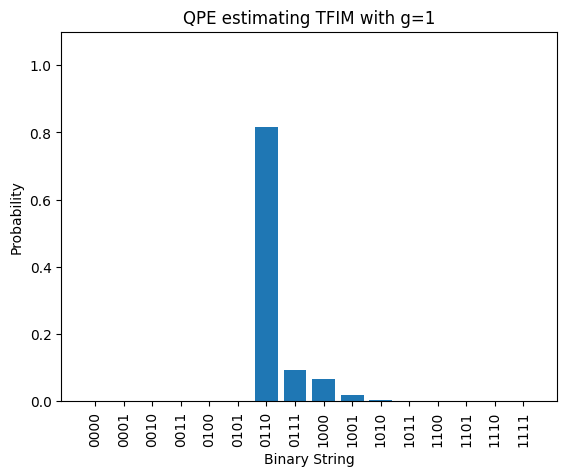

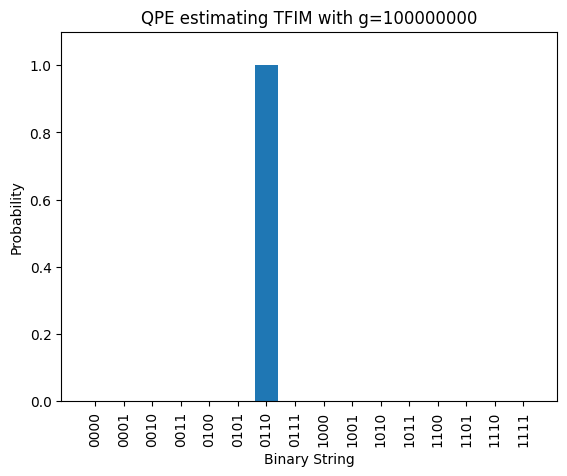

In [6]:
eigen_bits = 4
ancilla_bits = 4
gs = [0,1,10**8]

Hs = []
for g in gs:
    Hs.append(create_tfim_hamiltonian(eigen_bits, g, quiet=True))
    
qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(eigen_bits)
cr = ClassicalRegister(ancilla_bits)

qcs = []
for i in range(3):
    qcs.append(QuantumCircuit(qr_ancilla, qr_eigenstate, cr))
for i in range(3):
    qcs[i].h(qr_ancilla)
    if i  != 0:
        qcs[i].h(qr_eigenstate)
for index in range(3):
    H = Hs[index]
    qc = qcs[index]
    for i in range(ancilla_bits):
        mat = np.linalg.matrix_power(H, 2**(i))
        controlled_U = UnitaryGate(mat).control(annotated="yes")
        qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )
    qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)

for i in range(3):
    create_graph(eigen_bits, qcs[i], gs[i])

In every plot above, the computational basis state with the highest measurement probability corresponds to the ground state energy of the TFIM, indicating that QPE successfully identifies the correct eigenvalue regardless of the value of $g$. However, in the center plot, corresponding to the intermediate case where $g=1$, the probability of measuring the correct ground state $(0110)$ is notably lower than in the cases where $g=0$ and $g\gg 1$. This reduction stems from the more complex spectral structure at intermediate field strengths: the energy levels are more densely packed and the ground state is less isolated. As a result, the initial state used has non-negligible overlap with excited states, leading to a broader distribution of measurement outcomes. This highlights the importance of selecting an ansatz informed by the physical characteristics of the system. In regimes where eigenstates are not well-separated, accurate phase estimation requires a deeper understanding of the Hamiltonian's structure to ensure sufficient overlap with the target eigenstate.

For anyone who is curious, the code below can be used to fiddle with system parameters.

In [7]:
eigen_bits = 4
ancilla_bits = 4

g = 1
H = create_tfim_hamiltonian(eigen_bits, g)

H = -ZZII -IZZI -IIZZ -1*XIII -1*IXII -1*IIXI -1*IIIX 

Eigenvalues of the Hamiltonian:
 [0.375     +0.j 0.625     +0.j 0.39324507+0.j 0.57246542+0.j
 0.44577965+0.j 0.45548764+0.j 0.55422035+0.j 0.49197778+0.j
 0.50802222+0.j 0.60675493+0.j 0.42753458+0.j 0.47373271+0.j
 0.54451236+0.j 0.52626729+0.j 0.52626729+0.j 0.47373271+0.j]

Lowest energy Eigenvalue (0.3749999999999987+0j)


ANSATZ:


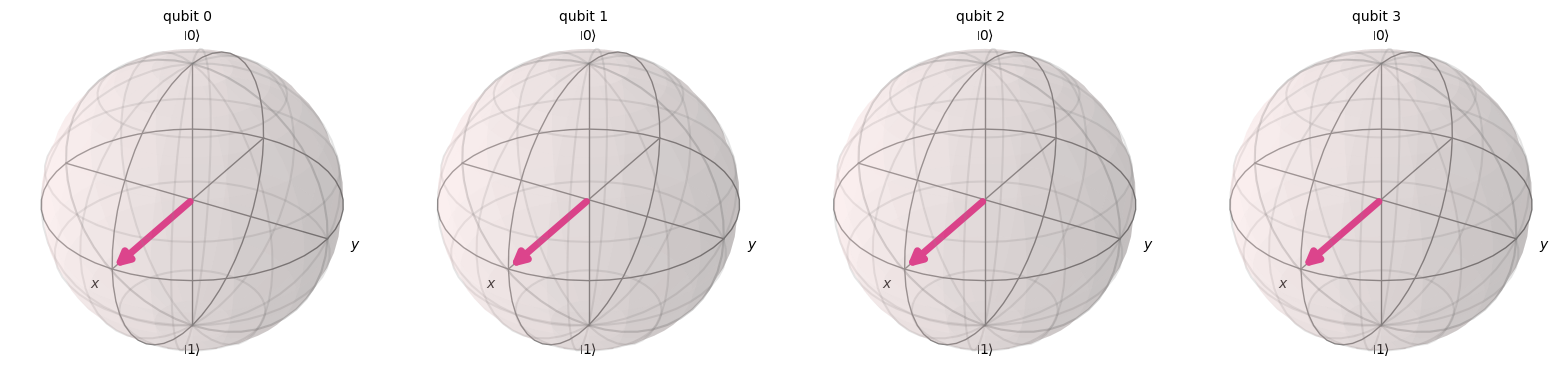

In [8]:
qr_eigenstate = QuantumRegister(eigen_bits)
qc = QuantumCircuit(qr_eigenstate)

# state preparation
if g >= 1:
    qc.h(qr_eigenstate)
else:
    qc.id(qr_eigenstate)
    # qc.x(qr_eigenstate)

sv = Statevector(qc)
print("ANSATZ:")
plot_bloch_multivector(sv)

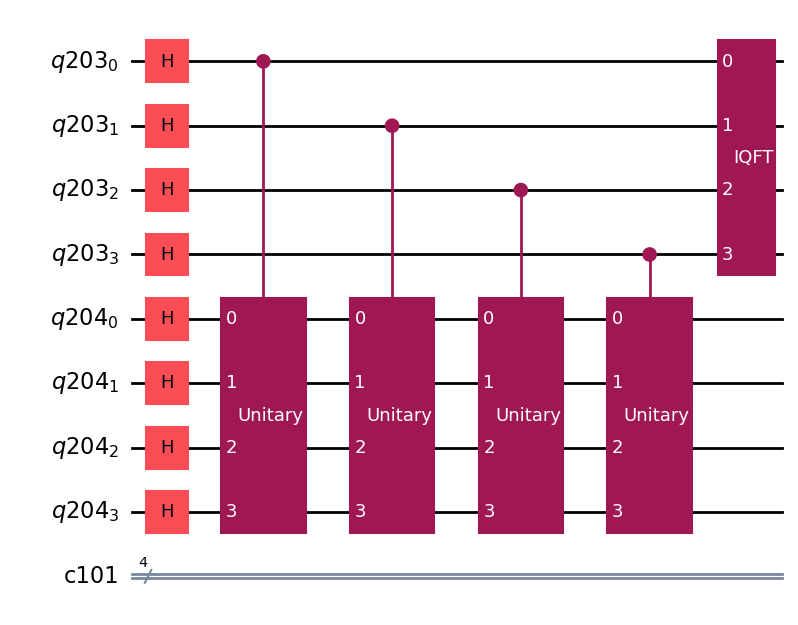

In [9]:
qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(eigen_bits)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

# state perparation
qc.h(qr_ancilla)
if g >= 1:
    qc.h(qr_eigenstate)
else:
    qc.id(qr_eigenstate)
    # qc.x(qr_eigenstate)


for i in range(ancilla_bits):
    mat = np.linalg.matrix_power(H, 2**(i))
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )

qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
qc.draw('mpl')

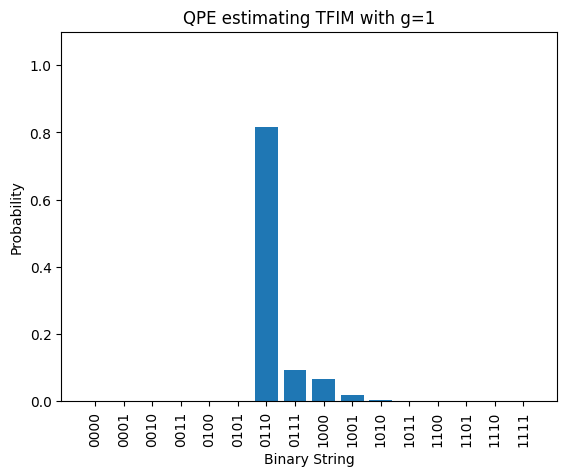

In [10]:
create_graph(eigen_bits, qc, g)

In [12]:
get_phase_from_qcircuit(eigen_bits, ancilla_bits, qc)

Binary Number Output: 0.0110
Decimal Number with Equivalent Value: 0.375


0.375